In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [29]:
import torch
from pyro import distributions as dists
from parameterized_curve import ParameterizedCurve, dist_as_curve
from ipywidgets import interact
from summary_stats import dist_pop

torch.manual_seed(12349)


torch_xx = torch.linspace(0.1, 5, 100, dtype=torch.double)
torch_yy = dists.SoftAsymmetricLaplace(
    loc=2,
    scale=0.5,
    asymmetry=2.9,
    softness=1).log_prob(torch_xx)


curve = dist_as_curve(dists.SoftAsymmetricLaplace)(
    n_groups=7, n_test=50, n_samples=30, scale=4, n_finish_epochs=100,
    loss_fn=lambda x, y: torch.mean(torch.square(torch.exp(x) - torch.exp(y))),
    # loss_fn=kld,
    pop=dist_pop)
curve.fit_initial(torch_xx, torch_yy)
curve.fit_finish()


@interact(**curve.interact_params())
def plot(**theta):
    transform = dists.transforms.ExpTransform()
    curve.plot_target(transform, model_label=r'$\theta^*$', theta=theta)
    curve.plot_target(transform, plot_real=False, model_label=r'$\theta_0$', theta=curve._theta_init)

interactive(children=(FloatSlider(value=1.9004099734508932, description='loc', max=13.158828090932184, min=-13…

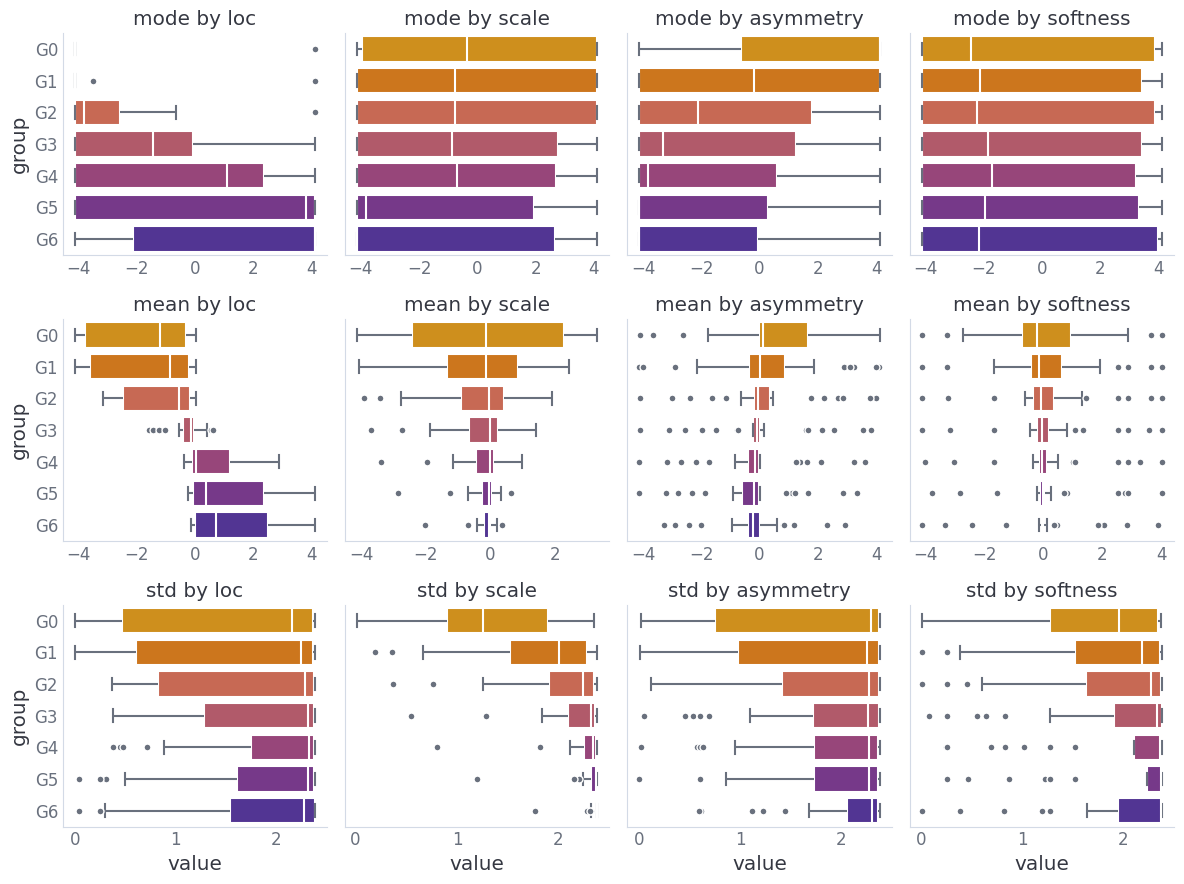

/home/nicholas/programs/rho_plus/rho_plus/util.py:57: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  return func(*new_args, **new_kwargs)


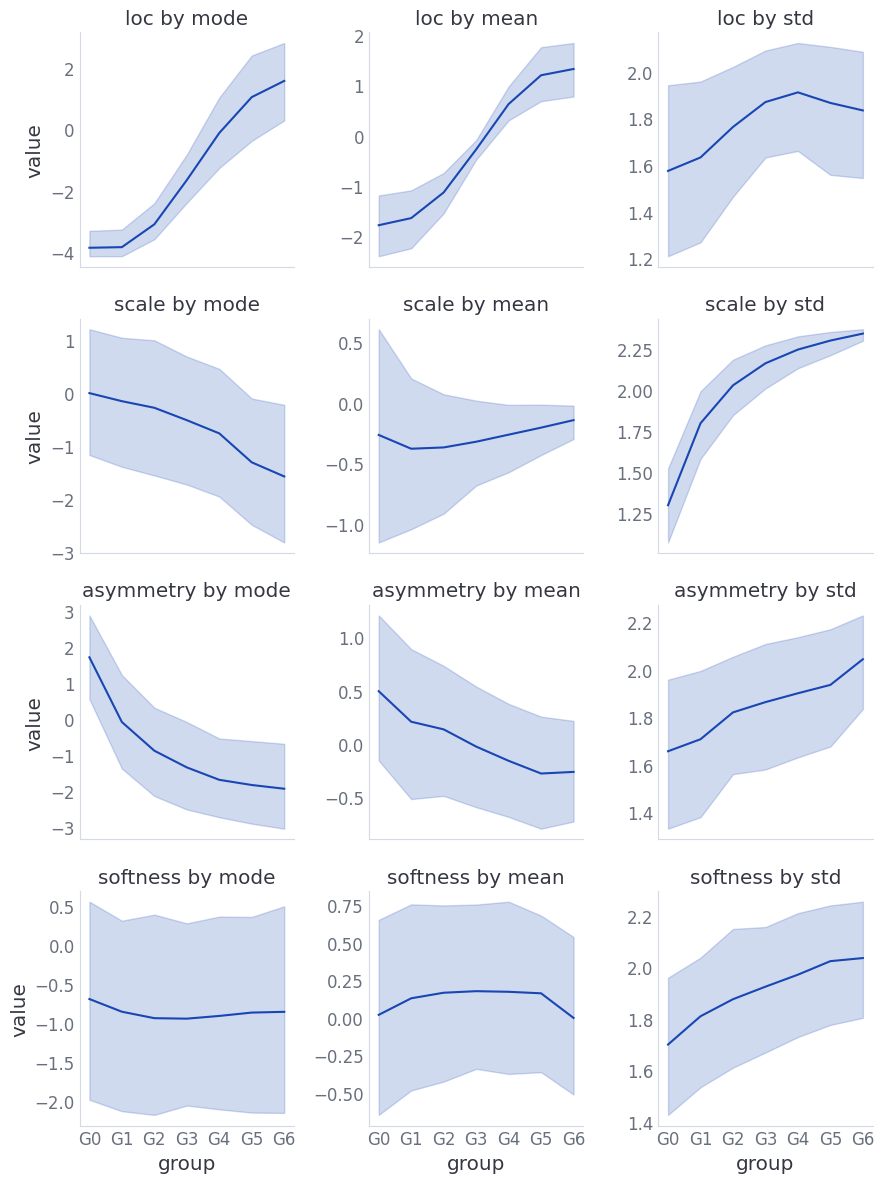

In [35]:
for p in curve.space.param_names:
    curve.space.unfix(p)
sdf = curve.pop_values()
sdf = sdf.melt(ignore_index=False, var_name='stat').reset_index()

g = sns.catplot(sdf, col='param', row='stat', y='group', hue='group',
                x='value', kind='box', palette='rho_sequential', legend=None, height=3,
                **rp.boxstyle(), sharex=False)

g.set_titles('{row_name} by {col_name}')
plt.show()

g = sns.relplot(sdf, row='param', col='stat', y='value', x='group', kind='line',
                palette='rho_sequential', legend=None, height=3, facet_kws=dict(sharey=False), estimator='mean')

g.set_titles('{row_name} by {col_name}')

In [36]:
curve._anova()

param      stat
loc        mode    35.797933
scale      std     14.783902
asymmetry  mode    13.368902
loc        mean     4.493649
scale      mode     3.571178
asymmetry  mean     0.102884
loc        std      0.068299
softness   mode     0.061610
           mean     0.044621
scale      mean     0.020899
asymmetry  std      0.000000
softness   std      0.000000
Name: F, dtype: float64

In [4]:
def xmax(x, y):
    return (x * torch.softmax(y, dim=-1)).sum(dim=-1, keepdim=True)

def ymax(x, y):
    return (y * torch.softmax(y, dim=-1)).sum(dim=-1, keepdim=True)

def xmin(x, y):
    return (x * torch.softmax(-y, dim=-1)).sum(dim=-1, keepdim=True)

def ymin(x, y):
    return (y * torch.softmax(-y, dim=-1)).sum(dim=-1, keepdim=True)


pop = {
    'xmax': xmax,
    'ymax': ymax,
    'xmin': xmin,
    'ymin': ymin
}

In [26]:
helium = pd.read_csv('data/helium_dimer.csv')

ljp_xx, ljp_yy = torch.tensor(helium.values.T)

import pyro.distributions.constraints as constrs
import pyro.distributions.transforms as transforms
from torch.distributions.constraints import Constraint

class LennardJonesPotential(ParameterizedCurve):
    @classmethod
    def arg_constraints(cls) -> dict:
        return {
            'ε': constrs.positive,
            'σ': constrs.positive,
        }

    @classmethod
    def support(cls) -> Constraint:
        return constrs.greater_than(2)

    @classmethod
    def _target_inner(cls, samples):
         ε = samples[..., 0]
         σ = samples[..., 1]
         def f(r):
            r_eff = σ / r
            return 4 * ε * (r_eff ** 12 - r_eff ** 6)
         return f

ljp = LennardJonesPotential(pop=pop, scale=10)
ljp.fit_initial(ljp_xx, ljp_yy)
ljp.fit_finish()

@interact(**ljp.interact_params())
def plot(**theta):
    transform = transforms.identity_transform
    margin = 0
    ljp.plot_target(transform, model_label=r'$\theta^*$', margin=margin, theta=theta)
    ljp.plot_target(transform, plot_real=False, model_label=r'$\theta_0$', margin=margin,theta=ljp._theta_init)

/home/nicholas/programs/exome/parameterized_curve.py:112: RuntimeWarning: invalid value encountered in double_scalars
  F = ms_treat / ms_err


interactive(children=(FloatSlider(value=6.807769466933363, description='ε', max=29.95731990495555, min=0.51293…

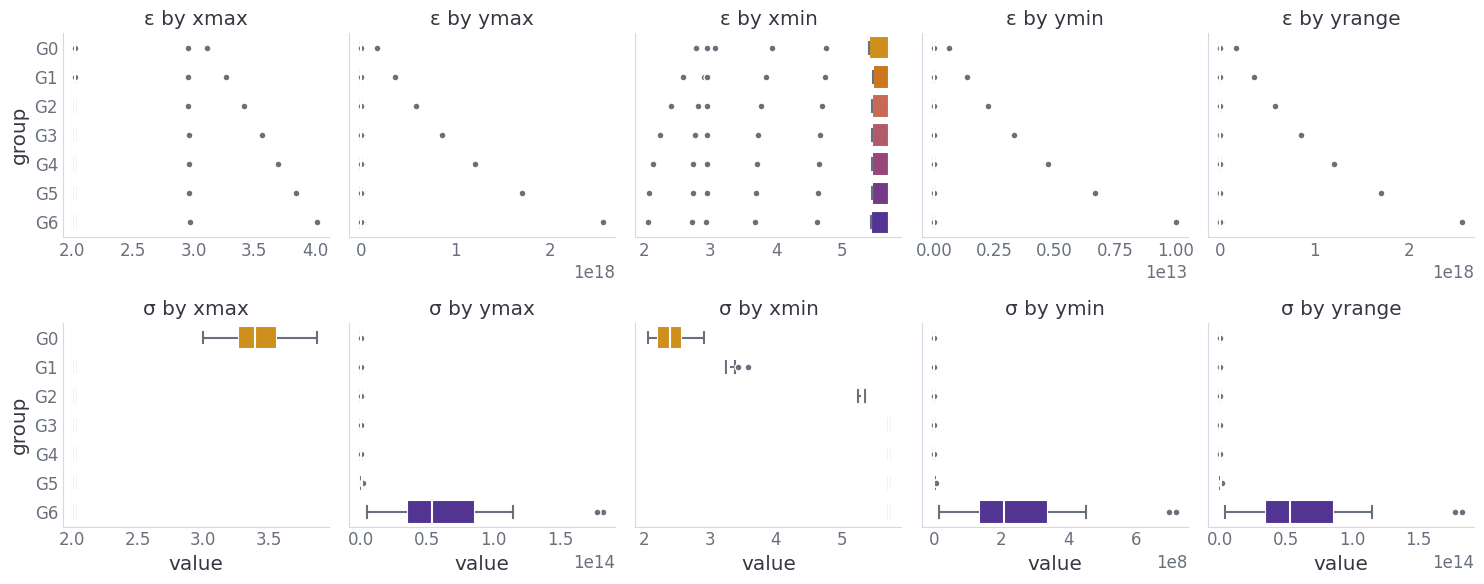

/home/nicholas/programs/rho_plus/rho_plus/util.py:57: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  return func(*new_args, **new_kwargs)


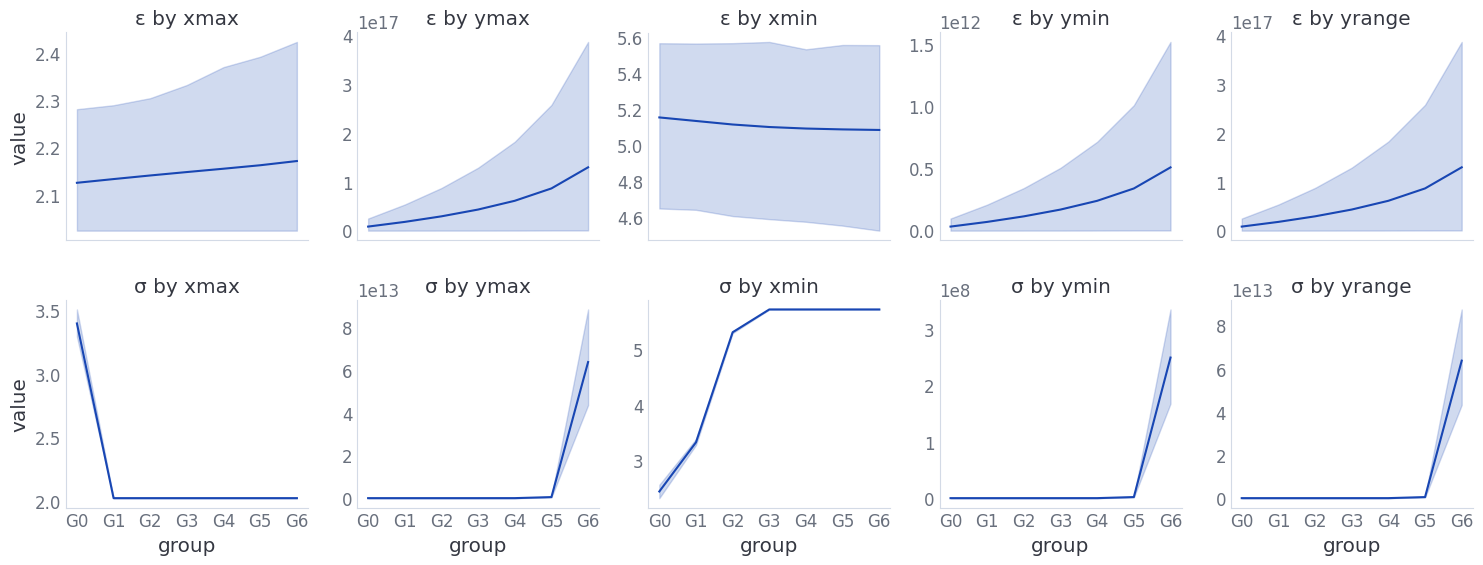

In [27]:
ljp.space.unfix('σ')
ljp.space.unfix('ε')
sdf = ljp.pop_values()
sdf = sdf.melt(ignore_index=False, var_name='stat').reset_index()

g = sns.catplot(sdf, row='param', col='stat', y='group', hue='group',
                x='value', kind='box', palette='rho_sequential', legend=None, height=3,
                **rp.boxstyle(), sharex=False)

g.set_titles('{row_name} by {col_name}')
plt.show()

g = sns.relplot(sdf, row='param', col='stat', y='value', x='group', kind='line',
                palette='rho_sequential', legend=None, height=3, facet_kws=dict(sharey=False), estimator='mean')

g.set_titles('{row_name} by {col_name}')

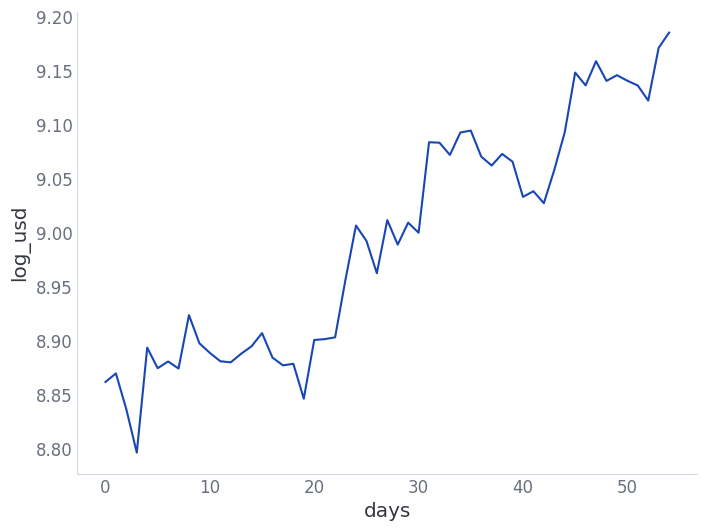

In [7]:

btc = pd.read_csv('data/BTC-Daily.csv')
btc['date'] = pd.to_datetime(btc['date'])
btc = btc[btc['date'] > pd.to_datetime('2019-12-13')]
btc = btc[btc['date'] < pd.to_datetime('2020-02-07')]
btc['days'] = (btc['date'] - btc['date'].min()).dt.days
btc['log_usd'] = np.log(btc['close'])
sns.lineplot(btc, x='days', y='log_usd')
lppl_xx = torch.tensor(btc['days'].values).double()
lppl_yy = torch.tensor(btc['log_usd'].values).double()

In [28]:
# https://mpra.ub.uni-muenchen.de/47869/1/MPRA_paper_47869.pdf
# equation 12
# Adjusted for clearer names

from torch.distributions.constraints import Constraint

def xmax(x, y):
    return (x * torch.softmax(y, dim=-1)).sum(dim=-1, keepdim=True)

def ymax(x, y):
    return (y * torch.softmax(y, dim=-1)).sum(dim=-1, keepdim=True)

def xmin(x, y):
    return (x * torch.softmax(-y, dim=-1)).sum(dim=-1, keepdim=True)

def ymin(x, y):
    return (y * torch.softmax(-y, dim=-1)).sum(dim=-1, keepdim=True)

def yrange(x, y):
    return ymax(x, y) - ymin(x, y)


pop = {
    'xmax': xmax,
    'ymax': ymax,
    'xmin': xmin,
    'ymin': ymin,
    'yrange': yrange,
}


class LPPL(ParameterizedCurve):
    @classmethod
    def arg_constraints(cls) -> dict:
        return {
            'p_c': constrs.positive,
            't_c': constrs.greater_than(lppl_xx.max() + 1),
            'slope': constrs.less_than(0),
            'beta': constrs.interval(0, 0.15),
            'wave_strength': constrs.positive,
            'wave_freq': constrs.positive,
            'wave_offset': constrs.interval(0, 2 * torch.pi),
        }

    @classmethod
    def support(cls) -> Constraint:
        return constrs.real

    @classmethod
    def _target_inner(cls, samples):
        p_c, t_c, slope, beta, wave_strength, wave_freq, wave_offset = samples.moveaxis(-1, 0)
        def f(t):
            t_eff = t_c - t
            return p_c + slope * t_eff ** beta * (
                1 + wave_strength * torch.cos(wave_freq * torch.log(t_eff) + wave_offset)
            )
        return f


lppl = LPPL(pop=pop, n_groups=11, n_samples=1000, n_test=120, scale=5)
lppl.fit_initial(lppl_xx, lppl_yy)
lppl.fit_finish()

@interact(**lppl.interact_params())
def plot(**theta):
    transform = transforms.identity_transform
    margin = 0.2
    lppl.plot_target(transform, model_label=r'$\theta^*$', margin=margin, theta=theta)
    lppl.plot_target(transform, plot_real=False, model_label=r'$\theta_0$', margin=margin,
                     theta=lppl._theta_init)

interactive(children=(FloatSlider(value=8.743467330932617, description='p_c', max=14.978660583496094, min=0.25…

In [9]:
for x in lppl.space.param_names:
    lppl.space.unfix(x)
anova = lppl._anova()
anova

param          stat  
wave_freq      xmax      1.933766e+01
slope          ymin      1.556027e+01
wave_freq      xmin      1.408648e+01
slope          yrange    6.571288e+00
wave_strength  ymax      3.428905e+00
wave_freq      yrange    3.118030e+00
wave_strength  yrange    2.961845e+00
wave_freq      ymin      1.560111e+00
p_c            ymax      1.382493e+00
wave_freq      ymax      1.288227e+00
p_c            ymin      1.149584e+00
slope          ymax      1.120950e+00
wave_strength  ymin      4.797341e-01
beta           ymin      1.116051e-01
wave_offset    ymin      5.032152e-02
               ymax      3.476984e-02
slope          xmax      3.398730e-02
               xmin      2.548175e-02
beta           yrange    1.341187e-02
wave_offset    xmax      1.113310e-02
               xmin      1.056093e-02
beta           xmin      3.686018e-03
               xmax      3.524709e-03
t_c            ymax      2.922334e-03
beta           ymax      2.196369e-03
t_c            xmin      9.1

In [10]:
for x in lppl.space.param_names:
    lppl.space.unfix(x)
lppl._anova()

param          stat  
wave_freq      xmax      1.933766e+01
slope          ymin      1.556027e+01
wave_freq      xmin      1.408648e+01
slope          yrange    6.571288e+00
wave_strength  ymax      3.428905e+00
wave_freq      yrange    3.118030e+00
wave_strength  yrange    2.961845e+00
wave_freq      ymin      1.560111e+00
p_c            ymax      1.382493e+00
wave_freq      ymax      1.288227e+00
p_c            ymin      1.149584e+00
slope          ymax      1.120950e+00
wave_strength  ymin      4.797341e-01
beta           ymin      1.116051e-01
wave_offset    ymin      5.032152e-02
               ymax      3.476984e-02
slope          xmax      3.398730e-02
               xmin      2.548175e-02
beta           yrange    1.341187e-02
wave_offset    xmax      1.113310e-02
               xmin      1.056093e-02
beta           xmin      3.686018e-03
               xmax      3.524709e-03
t_c            ymax      2.922334e-03
beta           ymax      2.196369e-03
t_c            xmin      9.1

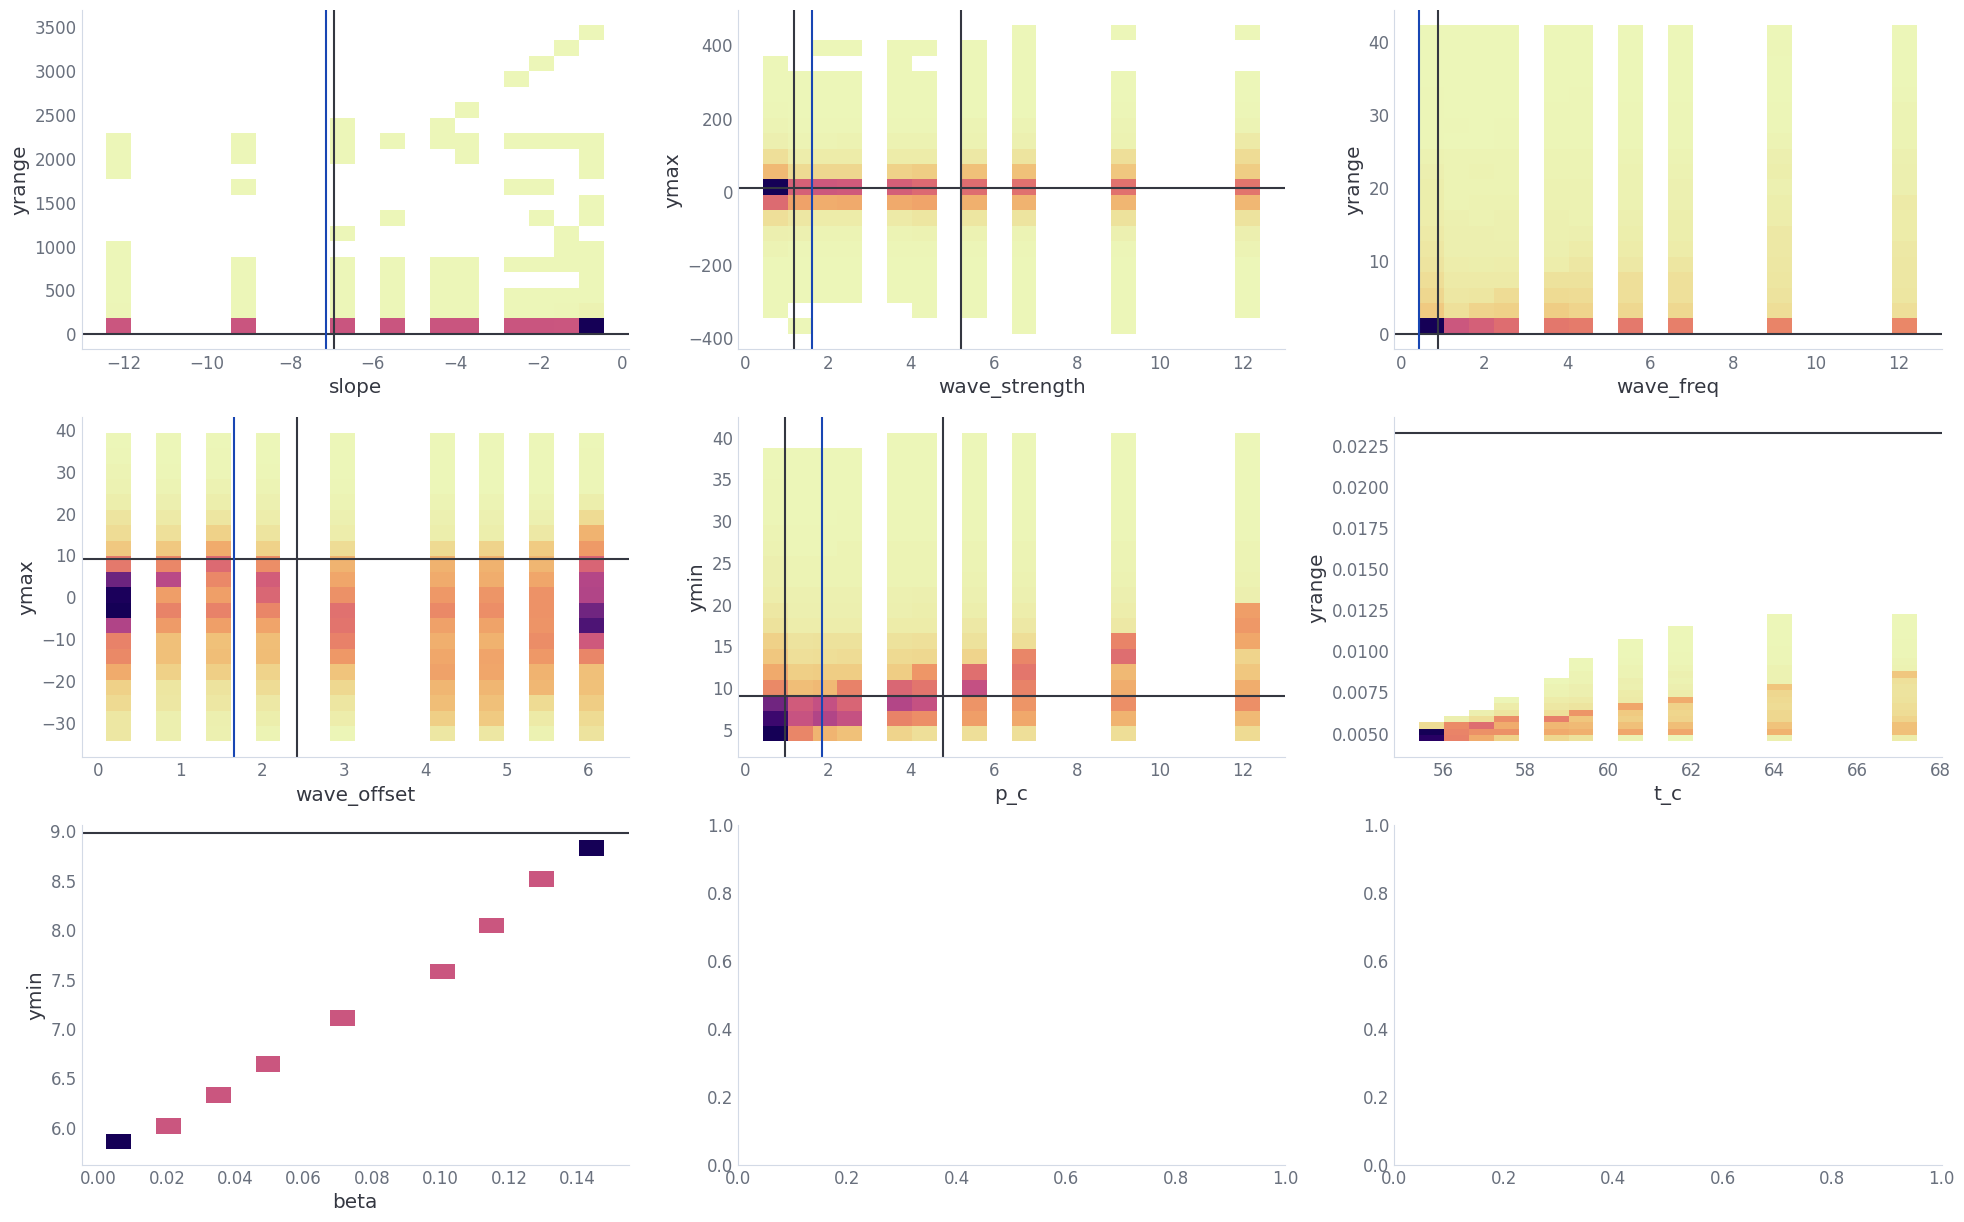

In [11]:
lppl.plot_diagnostics()

In [12]:
import gplearn

from gplearn.genetic import SymbolicRegressor, SymbolicTransformer

for p in lppl.space.param_names:
    lppl.space.unfix(p)
sdf = lppl.pop_values()

from funcs import to_np

samps, free_vars, free_is = lppl.space.free_sample_space()
samps = pd.DataFrame(to_np(samps.reshape(-1, len(free_vars))), columns=free_vars)
samps

mod = SymbolicTransformer(
    population_size=1000, generations=10,
    metric='spearman',
    function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt'],
    feature_names=sdf.columns,
    parsimony_coefficient='auto')
mod.fit(sdf, samps['p_c'])

SymbolicTransformer(feature_names=Index(['xmax', 'ymax', 'xmin', 'ymin', 'yrange'], dtype='object'),
                    function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt'],
                    generations=10, metric='spearman',
                    parsimony_coefficient='auto')

In [13]:
from torch.distributions.constraints import Constraint


ds_xx = torch.arange(8).double()
ds_yy = torch.tensor([0, 0.5, 3, 4, 1.8, 0.9, 0.4, 0.1])

class DoubleSigmoid(ParameterizedCurve):
    @classmethod
    def arg_constraints(cls) -> dict:
        return {
            'a': constrs.positive,
            'b1': constrs.positive,
            'b2': constrs.positive,
            'c1': constrs.positive,
            'c2': constrs.positive,
        }

    @classmethod
    def _target_inner(cls, samples):
        a, b1, b2, c1, c2 = samples.movedim(-1, 0)
        def f(x):
            sig1 = torch.sigmoid(b1 * (x - c1))
            sig2 = torch.sigmoid(b2 * (x - c2))
            return a * (sig1 - sig2)
        return f


double_sigmoid = DoubleSigmoid(pop=pop, n_groups=6, n_samples=100, scale=3, n_finish_epochs=1000)
double_sigmoid.fit_initial(ds_xx, ds_yy)
double_sigmoid.fit_finish()

@interact(**double_sigmoid.interact_params())
def plot(**theta):
    transform = transforms.identity_transform
    margin = 0.2
    double_sigmoid.plot_target(transform, model_label=r'$\theta^*$', margin=margin, theta=theta)
    double_sigmoid.plot_target(transform, plot_real=False, model_label=r'$\theta_0$',
                               margin=margin, theta=double_sigmoid._theta_init)

interactive(children=(FloatSlider(value=5.623815213179365, description='a', max=8.987195837567013, min=0.15387…

In [14]:
for p in double_sigmoid.space.param_names:
    double_sigmoid.space.unfix(p)
sdf = double_sigmoid.pop_values()
sdf

xmax      ymax      xmin      ymin        yrange
param group sample                                                      
a     G0    S0      0.000172  0.000051 -0.000172  0.000051  6.577102e-08
            S1     -0.004163 -0.002939  0.004175 -0.002952  1.257099e-05
            S2      0.085354 -0.088576 -0.073432 -0.098680  1.010454e-02
            S3     -0.000083 -0.000031  0.000083 -0.000031  8.803909e-09
            S4      0.334187  0.246916 -0.320839  0.161871  8.504570e-02
...                      ...       ...       ...       ...           ...
c2    G5    S95     2.315613  5.245127 -1.897696  0.499277  4.745850e+00
            S96    -1.374876 -1.128756  2.547997 -3.971742  2.842986e+00
            S97    -0.000906 -0.000488  0.000907 -0.000489  6.766350e-07
            S98     0.000021  0.000006 -0.000021  0.000006  1.354238e-09
            S99     3.773005  7.612512 -0.790286  0.157512  7.455000e+00

[3000 rows x 5 columns]

In [15]:
from funcs import to_np


samps, free_vars, free_is = double_sigmoid.space.free_sample_space()
samps = pd.DataFrame(to_np(samps.reshape(-1, len(free_vars))), columns=free_vars)
samps

,a,b1,b2,c1,c2
0,0.462452,1.768590,2.783227,7.306813,6.991997
1,0.462452,3.156637,0.449473,6.198395,11.955308
2,0.462452,1.364473,0.299825,2.093595,1.673877
3,0.462452,6.217966,1.015728,16.458744,10.966166
4,0.462452,4.705029,4.462454,0.285677,4.407034
...,...,...,...,...,...
2995,5.914905,1.424649,6.884566,0.385924,5.837730
2996,16.833492,0.802353,0.384545,14.456295,5.837730
2997,0.012491,14.133156,0.654175,7.864709,5.837730
2998,0.367195,2.382353,5.751015,7.163229,5.837730
